# Определение возраста покупателей

## Исследовательский анализ данных

**Описание проекта**

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
Контролировать добросовестность кассиров при продаже алкоголя.
Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

In [1]:
# импортируем необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# сохраняем константы
SEED = 12345

In [2]:
# Сохраним датасет с реальным возрастом в переменную ages
ages = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
# с помощью загрузчика данных извлечем изображения и возраст людей на них
datagen = ImageDataGenerator(rescale=1./255)
datagen_flow = datagen.flow_from_dataframe(
        dataframe=ages,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=SEED)

Found 7591 validated image filenames.


In [4]:
# изучим распределение по возрасту
ages.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [1]:
# с помощью библиотеки plotly выведем интерактивную гистограмму распределения по возрасту
fig = go.Figure(data=[go.Histogram(x=ages['real_age'])])
fig.update_layout(
    title_text='Распределение возраста в датасете', # title of plot
    xaxis_title_text='Возраст', # xaxis label
    yaxis_title_text='Количество', # yaxis label
    bargap=0.2, # gap between bars of adjacent location coordinates
    bargroupgap=0.2 # gap between bars of the same location coordinates
)
fig.show()

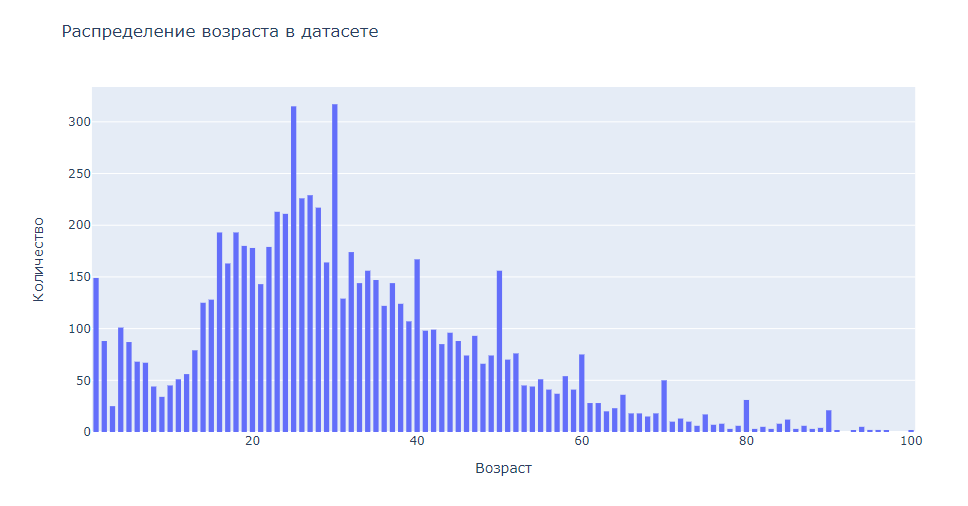

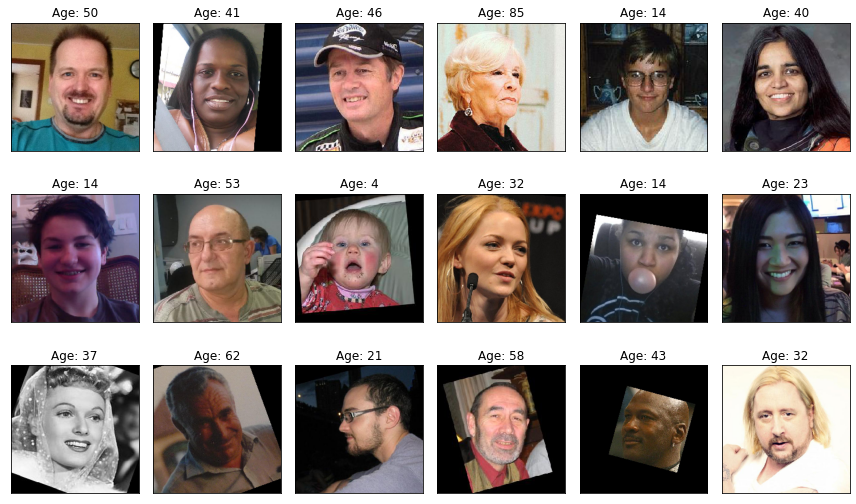

In [6]:
# выведем на экран 15 фотографий
image, age = next(datagen_flow)
fig = plt.figure(figsize=(12, 8))
for i in range(18):
    fig.add_subplot(3, 6, i+1)
    plt.imshow(image[i])
    plt.title(f'Age: {age[i]}')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

- В датасете 7591 фотография. 
- Среднее значение возраста 32 года. 
- Распределение от 1 года до 100 лет. 

**Проблемы выявленные в датасете:**

- Есть пропуски (отсутствуют фото людей 91, 92, 98, 99 лет). 
- Очень мало фото людей в диапазоне от 71 до 100. 
- В данных имеются фото развернутые на черном фоне. 
- Ч/б фото.
- Фото в профиль.
- Фото на которых лицо не полностью попадает в кадр.

Все это может негативно повлиять на результаты модели.

## Обучение модели

```python

import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Dense, AvgPool2D, Flatten
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.optimizers import Adam

optimizer = Adam(lr=0.0001)

SEED = 12345

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25,
                                       rescale=1/255,
                                       horizontal_flip=True)
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=SEED)

    return train_datagen_flow


def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    val_datagen = ImageDataGenerator(validation_split=0.25, rescale=1. / 255)
    val_datagen_flow = val_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=SEED)

    return val_datagen_flow


def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(AvgPool2D())
    model.add(Flatten())
    model.add(Dense(units=3, activation='relu'))
    model.add(Dense(units=1, activation='relu'))
    model.compile(optimizer=optimizer, loss=MeanAbsoluteError(), metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=15,
                steps_per_epoch=None, validation_steps=None):

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

```

Found 5694 validated image filenames.
Found 1897 validated image filenames.

Train for 178 steps, validate for 60 steps
Epoch 1/15
2023-04-15 21:39:15.899419: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-04-15 21:39:16.183601: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 49s - loss: 9.8510 - mae: 9.8514 - val_loss: 20.3951 - val_mae: 20.3901
Epoch 2/15
178/178 - 40s - loss: 6.9040 - mae: 6.9043 - val_loss: 13.7821 - val_mae: 13.7477
Epoch 3/15
178/178 - 40s - loss: 5.9755 - mae: 5.9760 - val_loss: 12.0871 - val_mae: 12.0545
Epoch 4/15
178/178 - 41s - loss: 5.1434 - mae: 5.1438 - val_loss: 8.4236 - val_mae: 8.4351
Epoch 5/15
178/178 - 40s - loss: 4.7256 - mae: 4.7254 - val_loss: 9.6710 - val_mae: 9.6467
Epoch 6/15
178/178 - 40s - loss: 4.2468 - mae: 4.2472 - val_loss: 6.5915 - val_mae: 6.6216
Epoch 7/15
178/178 - 41s - loss: 4.0810 - mae: 4.0815 - val_loss: 7.0667 - val_mae: 7.0795
Epoch 8/15
178/178 - 40s - loss: 3.7731 - mae: 3.7727 - val_loss: 6.4148 - val_mae: 6.4078
Epoch 9/15
178/178 - 41s - loss: 3.6373 - mae: 3.6376 - val_loss: 6.6780 - val_mae: 6.7043
Epoch 10/15
178/178 - 41s - loss: 3.3591 - mae: 3.3589 - val_loss: 6.1157 - val_mae: 6.1247
Epoch 11/15
178/178 - 49s - loss: 3.3127 - mae: 3.3130 - val_loss: 5.8214 - val_mae: 5.8498
Epoch 12/15
178/178 - 50s - loss: 3.1286 - mae: 3.1284 - val_loss: 5.8982 - val_mae: 5.9121
Epoch 13/15
178/178 - 44s - loss: 3.0555 - mae: 3.0557 - val_loss: 6.4168 - val_mae: 6.4227
Epoch 14/15
178/178 - 48s - loss: 2.8868 - mae: 2.8869 - val_loss: 5.9707 - val_mae: 5.9824
Epoch 15/15
178/178 - 51s - loss: 2.7880 - mae: 2.7880 - val_loss: 5.7754 - val_mae: 5.7795

60/60 - 11s - loss: 5.7754 - mae: 5.7795
Test MAE: 5.7795

```

## Анализ обученной модели

Нам нужно было добиться MAE ниже 8, модель с использованием ResNet50 на тесте показала лучший результат из всех опробованных архитектур. MAE=5.7795. Следовательно поставленную задачу можно считать выполненной.

При доработке обучающей выборки (проблемы были описаны выше) можно будет улучшить этот результат.